# Script to azimutally integrate 2D scattering images to 1D curves

How to do

## Preparations
### Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M
from scipy import optimize
import scipy.constants as con
import os

### custom colormap

In [2]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read and display single images for instrumental calibration

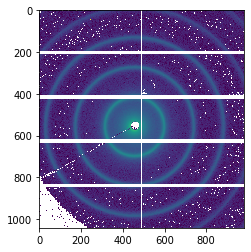

In [22]:
# give the image directory
image_dir = 'files\Data_for_ASAXS'
# give the generic image name and file ending (e.g. >.tif<)
image_name = 'pilatus_2020kw29tg14_'
image_type = '.tif'

# give the number of the image you like to display
image_number = '00380'

image_path = image_dir + os.sep + image_name + image_number + image_type
image_object = fabio.open(image_path)
image = image_object.data
# print(image_object.header)

fig, ax = plt.subplots()
ax.imshow(image, norm=LogNorm())

## Calibrate beam center and distance
### Find the beam center on the detector

In [57]:
# some general function needed for that

# a gaussian circle
def gauss_circle(x, y, x0, y0, r, sigma):
    return np.exp(-(np.sqrt((x0 - x)**2+(y0 - y)**2) - r)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

# a simple circle
def in_circle(x, y, x0, y0, r):
    return (x - x0)**2 + (y - y0)**2 < r**2

# fitfunction 
def fun(x):
    x0, y0, r = x
    fun_val = -np.sum(image * gauss_circle(X, Y, x0, y0, r, sigma) * mask)\
    / np.sum(gauss_circle(X, Y, x0, y0, r, sigma) * mask)
    return fun_val

In [58]:
# for preparations for the image

# produce a meshgrid with x and y components
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# automated masking of negative values and hot-pixels or areas with much to high count
def create_mask(img, *args, ul=1e6, ll=0):
    mask = img < ll
    mask[img > ul] = True
    for arg in args:
        mask[arg] = True
    return mask

In [59]:
# Center search by circle fitting of a bragg peak

# give starting parameters
x0 = 450
y0 = 550
radius = 140
sigma = 1

# mask the center of the image to ease the optimization procedure
radius_centerMask = 100
mask = ~create_mask(image, in_circle(X, Y, x0, y0, radius_centerMask))

res = optimize.minimize(fun, [x0, y0, radius], method='Nelder-Mead')
res

 final_simplex: (array([[456.73553284, 556.57911939, 141.42583486],
       [456.7355316 , 556.5792013 , 141.42589574],
       [456.73545339, 556.57907703, 141.42586841],
       [456.73556312, 556.5791654 , 141.42591721]]), array([-1045.24735026, -1045.24735023, -1045.2473502 , -1045.24735001]))
           fun: -1045.2473502564205
       message: 'Optimization terminated successfully.'
          nfev: 133
           nit: 70
        status: 0
       success: True
             x: array([456.73553284, 556.57911939, 141.42583486])

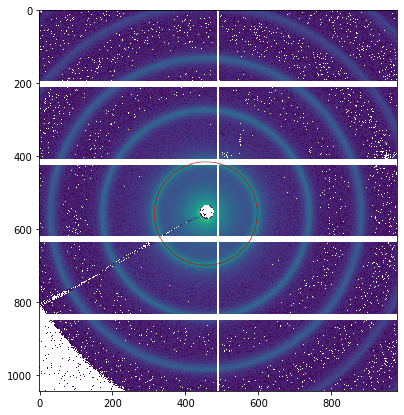

In [60]:
# Plot test image with fitted circle
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(image, norm=LogNorm())
ax.imshow(gauss_circle(X, Y, res['x'][0], res['x'][1], res['x'][2], sigma), cmap='red_alpha')

### calculate distance
$q = \frac{4\pi}{\lambda}\cdot\sin{\theta}$


$\tan{2\theta} = \frac{\mathrm{radius}}{\mathrm{dist}}$


$\mathrm{dist} = \mathrm{radius}\cdot(\tan{2\theta})^{-1} = \mathrm{radius} \cdot (\tan{(2\arcsin{\frac{q \lambda}{4\pi}})})^{-1}$

In [91]:
# give the pixel size in meter
pixelsize = 172e-6

# give the position of the before fitted bragg peak
# for Silver-Behenate (Ag-beh) 1.070057 nm^-1
q_peak = 1.070057  # in nm^-1
q_peak = 1.078  # in nm^-1

# give the experimental X-ray energy
energy_calibration = 7000 # in eV

#calculate wavelength, scattering angle and sample to detector distance
wavelength = con.h * con.c / con.e / energy_calibration  # m
theta = np.arcsin(wavelength * 1e9 * q_peak/ 4 / np.pi)
dist = res['x'][2] * pixelsize / np.tan(2 * theta)  # m
print("sample-detector distance = {} m".format(round(dist, 5)))

sample-detector distance = 0.8002 m


## Azimuthal Integration

In [76]:
# for real data use also mask option of AI class
# notice that poni1 correspond to y and poni2 to x coordinate of detector
# for more information on geometry visit (figure at bottom of page):
# https://pyfai.readthedocs.io/en/latest/usage/tutorial/Geometry/geometry.html

ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=res['x'][1]*pixelsize, poni2=res['x'][0]*pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
ai

  File "<ipython-input-76-dc60f8fbe1e6>", line 7, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.771203e-10m
SampleDetDist= 8.061459e-01m	PONI= 9.573161e-02, 7.855851e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 806.146mm	Center: x=456.736, y=556.579 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

### Masking
Generate a mask file (as name.edf, name.tif, ...) and load it to ai_mask via ai_mask_path.
The recommended procedure is the following: 
1. open a python console or anaconda promped
2. optional change to the the image directory via >>cd path\to\data<<
3. type >>pyFAI-drawmask filename.tif<< or >>pyFAI-drawmask path\to\data\filename.tif<<

A GUI will open with the specified image file. With the GUI a mask can be generated and saved. 
Save it and use it below.

In [99]:
# adress the mask
ai_mask_path = image_dir + os.sep + 'mask_shot.edf'
ai_mask_object = fabio.open(ai_mask_path)
ai_mask = ai_mask_object.data

# usage of integrate 1d method
q, I, e = ai.integrate1d(image, 800, error_model='poisson', mask=ai_mask)

### Do the integration

In [100]:
# usage of integrate 1d method
q, I, e = ai.integrate1d(image, 800, error_model='poisson', mask=ai_mask)

[]

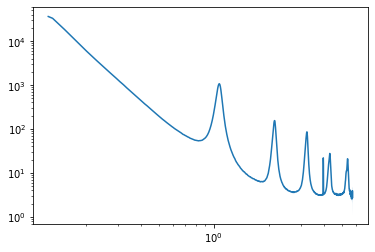

In [102]:
# Display the azimuthal integration result
scale = 1  # upscaling of poisson error for visibility

fig, ax = plt.subplots()
ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
ax.plot(q, I)
ax.loglog()
#ax.set_xlim([0.05, 1.81])

In [66]:
# for additional info uncomment line below
ai.integrate1d??

In [65]:
pyFAI.AzimuthalIntegrator??